In [2]:
import numpy  as np 
import pandas as pd 
import os
import cv2 
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.activations import sigmoid
from keras.optimizers import Adam

# Global constants
IMG_DIM      = 256
BATCH_SIZE   = 32
NUM_CLASSES  = 5
CHANNEL_SIZE = 3

pre_process = str(IMG_DIM) + "_ben_normal_"

# pre_process = "ben_weird_"

# pre_process = "clahe_green_"


# Loading data

In this kernel, we are using multilabel data. Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. 

The idea is that if an eye has severe diabetic retinopathy, that also means that it has moderate and severe diabetic retinopathy

In [27]:
# data frame of current competition
# df_2019 = pd.read_csv("../aptos2019/train.csv") 
# df_2019.processed = df_2019.id_code.apply(lambda x: pre_process + x + ".png")
# df_2019["original"]  = df_2019.id_code.apply(lambda x: x + ".png")
# df_2019["processed"] = df_2019.original.apply(lambda x: pre_process + x)
# # train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, shuffle=False) not for python 3.5
# train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, random_state=42)

# 2019 data frame 
df_2015 = pd.read_csv("../aptos2015/trainLabels.csv") 
df_2015["original"]  = df_2015.image.apply(lambda x: x + ".jpeg")
df_2015["processed"] = df_2015.original.apply(lambda x: pre_process + x)
df_2015["diagnosis"] = df_2015.level
# train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, shuffle=False)
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, random_state=42)

# valid_2019['diagnosis'].value_counts().plot(kind='bar')
# print(valid_2019[:3])
# plt.title('Samples Per Class')


In [19]:
def label_convert(y_val):
    y_val = y_val.astype(int).sum(axis=1) - 1
    return y_val

def get_train_valid_df(year="2019", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(x+1)])
    valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(x+1)])

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())

        for diagnosis in range(5):
            indexes_valid = valid[valid['diagnosis'] == diagnosis].index
            indexes_train = train[train['diagnosis'] == diagnosis].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution
    train = train.sample(frac=0.8)
    valid = valid.sample(frac=0.8)
    
    return train, valid

df_sample, _ = get_train_valid_df(year="2015")
print(df_sample.head())

           image  level         original                       processed  \
5269  6617_right      2  6617_right.jpeg  256_ben_normal_6617_right.jpeg   
5341  6719_right      4  6719_right.jpeg  256_ben_normal_6719_right.jpeg   
6        16_left      4     16_left.jpeg     256_ben_normal_16_left.jpeg   
1180   1452_left      0   1452_left.jpeg   256_ben_normal_1452_left.jpeg   
385    439_right      4   439_right.jpeg   256_ben_normal_439_right.jpeg   

      diagnosis           labels  
5269          2        [0, 1, 2]  
5341          4  [0, 1, 2, 3, 4]  
6             4  [0, 1, 2, 3, 4]  
1180          0              [0]  
385           4  [0, 1, 2, 3, 4]  


<Figure size 1584x1440 with 0 Axes>

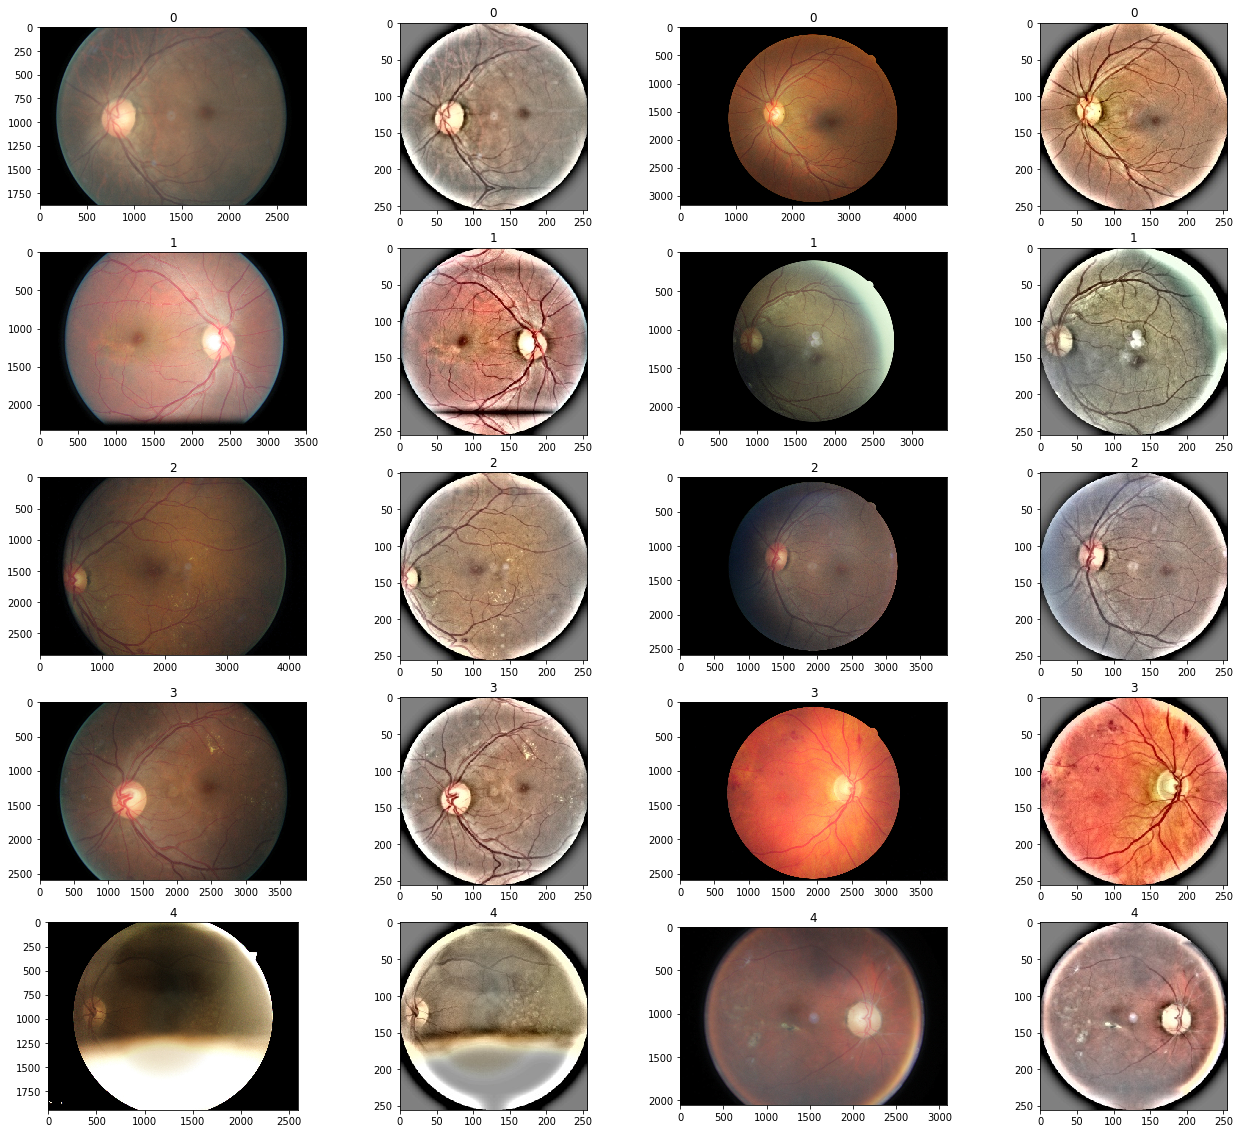

In [22]:
# display some data
def display_data():
    df_example, _ = get_train_valid_df(year="2015")

    # Display some random images from Data Set with class categories.
    figure=plt.figure(figsize=(22,20))
    for target_class in range(5):
        for i, file_name in enumerate(df_example[df_example.diagnosis == target_class].original.sample(2)):
            
            # open the file
            o_img = cv2.imread("../aptos2015/train_images/" + file_name)
            p_img = cv2.imread("../aptos2015/train_images/" + pre_process + file_name)

            o_rgb = cv2.cvtColor(o_img, cv2.COLOR_BGR2RGB)
            p_rgb = cv2.cvtColor(p_img, cv2.COLOR_BGR2RGB)
            
            ax = figure.add_subplot(5,4, int(target_class)*4+2*i+1)
            plt.imshow(o_rgb)
            ax.set_title(target_class)
            
            ax = figure.add_subplot(5,4, int(target_class)*4+2*i+2)
            plt.imshow(p_rgb)
            ax.set_title(target_class)
    
    plt.show()
            
display_data()

In [14]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True and (jitter > 0.01), 
                                       vertical_flip=True and (jitter > 0.01),
                                       rotation_range=int(600*jitter),
                                       brightness_range=[1-jitter/3, 1+jitter/3],
                                       channel_shift_range=int(30*jitter),
                                       zoom_range=[max(0.7, 1-5*jitter), 1],
                                       fill_mode="constant",
                                       cval=128.,
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="processed", 
                                       y_col='labels', 
                                       class_mode="categorical", 
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019", even_distrib=True):
    
    train, valid = get_train_valid_df(year=year, even_distrib=even_distrib) 
    datagen_jittered = dataGenerator(jitter)
    datagen_clean = dataGenerator(0.02)
    
    train_gen = datagen_with_flow(datagen_jittered, train, "../aptos" + year + "/train_images/")
    valid_gen = datagen_with_flow(datagen_clean, valid, "../aptos" + year + "/train_images/")
    
    return train_gen, valid_gen

gc.collect()


3583

Found 628 validated image filenames belonging to 5 classes.
Found 145 validated image filenames belonging to 5 classes.


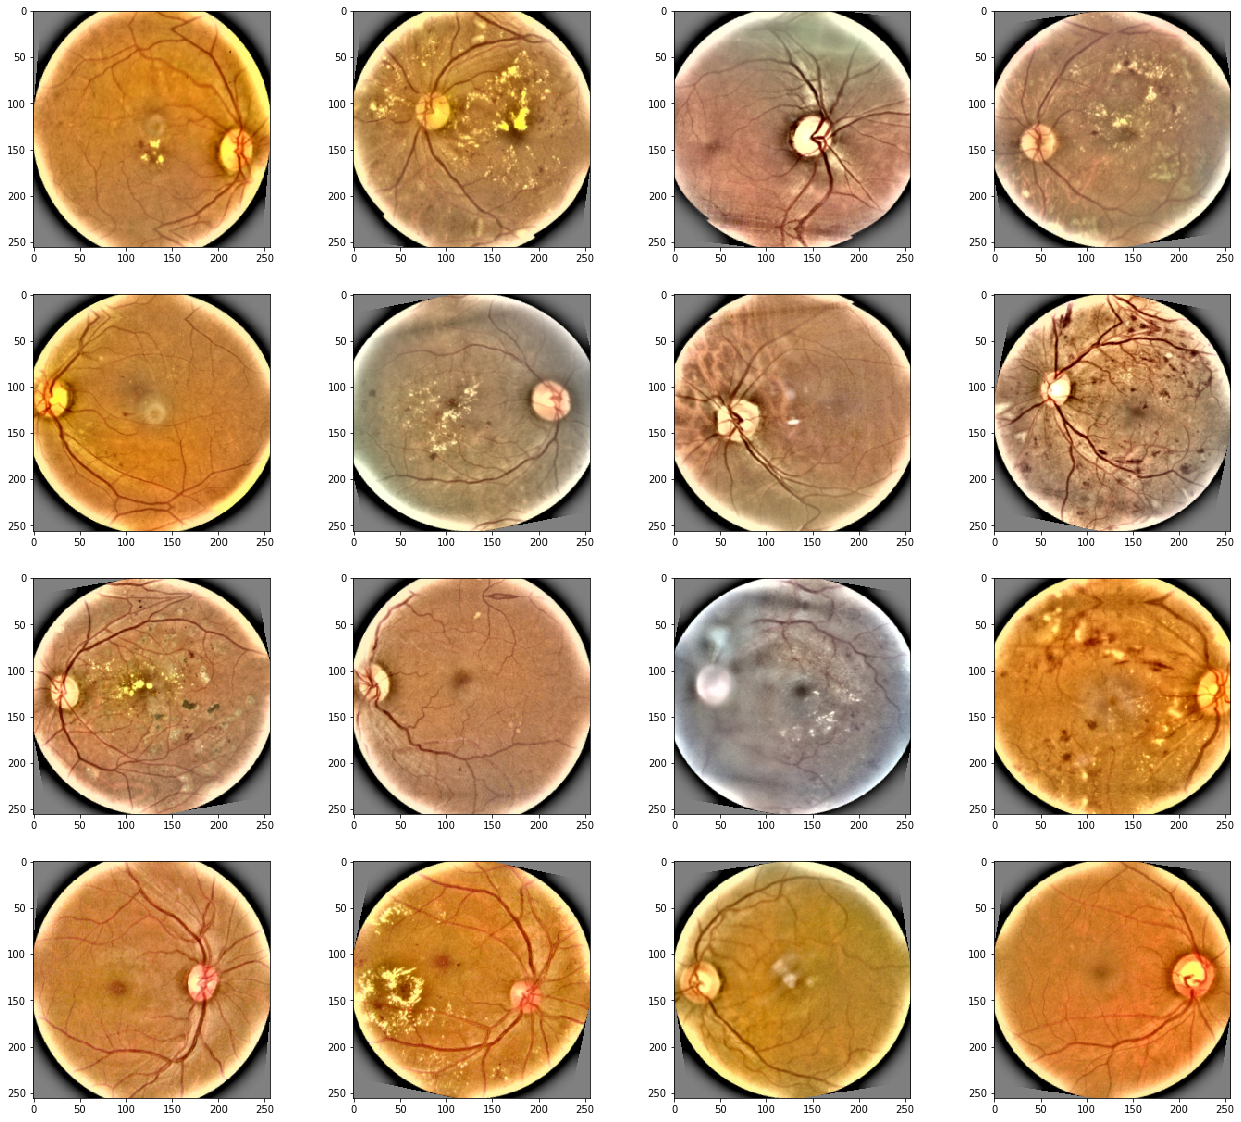

In [15]:
train_sample_gen, valid_sample_gen = generator(jitter=0.05)

# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in valid_sample_gen:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break
plt.show()

In [11]:
class Metrics(Callback):
    def __init__(self, generator):
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        numBatches = 20
        y_pred     = []
        y_val      = []
        for x, y in self.generator:
            predictions = model.predict(x) 
            y_pred.extend(label_convert(predictions > 0.5))
            y_val.extend(label_convert(y))
            
            numBatches -= 1
            if numBatches <= 0:
                break
            
        val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        self.val_kappas.append(val_kappa)
        
        print(confusion_matrix(y_val, y_pred), val_kappa)
            
        if val_kappa == max(self.val_kappas) and val_kappa > 0.85:
            gc.collect()
            print("Max of this run, saving model.")
            model.save(str(val_kappa) + ".h5")


In [12]:
def create_model():
    
    model = Sequential()
    model.add(DenseNet121(weights='../DenseNet-BC-121-32-no-top.h5', 
#     model.add(DenseNet121(weights=None, 
                          include_top=False, 
                          input_shape=(IMG_DIM, IMG_DIM, CHANNEL_SIZE)))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    return model

model = create_model()
# model.load_weights("ben_normal_-0.8863.h5")
# model.load_weights("ben_weird_-0.8784.h5")



In [ ]:
for year in ["2019"]:
    for jitter in [0.03, 0.1]:
    
        model.compile(optimizer=Adam(lr=0.000005*jitter), loss='binary_crossentropy',  metrics=['accuracy'])
        # started at 0.00003. Seems to still change somewhat with even 0.000005

        print("           -----------------------------------", year, 
              jitter, "-----------------------------------")

        for even_distrib in [False, True, False, False, True]:

            print("           -   -   -   -   -   -   -   -   ", 
                  even_distrib, "-   -   -   -   -   -   -   -   -")
            
            # these need to be global for the kappa callback
            train_generator, valid_generator = generator(jitter=jitter, year=year, even_distrib=even_distrib)

            # Call backs during training            
            kappa_callbacks = Metrics(valid_generator)
            reduce_lr  = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, 
                                           min_lr=1e-8, mode='auto', verbose=1)

            # train the model for 12 epochs
            history = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                          validation_data=valid_generator,
                                          validation_steps=valid_generator.n // valid_generator.batch_size,
                                          epochs=4, workers=4, verbose=1,
                                          callbacks=[reduce_lr, kappa_callbacks],
                                         )
    
    gc.collect()

           ----------------------------------- 2019 0.03 -----------------------------------
           -   -   -   -   -   -   -   -    False -   -   -   -   -   -   -   -   -
Found 2343 validated image filenames belonging to 5 classes.
Found 586 validated image filenames belonging to 5 classes.
Epoch 1/4
73/73 [==============================] - 143s 2s/step - loss: 0.2783 - acc: 0.8769 - val_loss: 0.1826 - val_acc: 0.9236
[[264  23   4   0   0]
 [  2  22  27   6   0]
 [  1   7  68  99   4]
 [  0   0   2  22   7]
 [  0   0   3  36  21]] 0.8822791912279122
Max of this run, saving model.
Epoch 2/4
16/73 [=====>........................] - ETA: 1:20 - loss: 0.2670 - acc: 0.8840

In [ ]:
model.save(f"{pre_process}-201[59]-run.h5")

# Compare the average of 5 randomised jitters to a non-jittered val

In [ ]:
# def compare_prediction_process(year="2019"):

#     _, valid_df = get_train_valid_df(year=year, even_distrib=False)
    
#     y_val  = valid_df.diagnosis.astype(int)

#     # with jitter
#     num = 7
#     prediction_lists = np.zeros((valid_df.index.size, num, 5))
#     for i in range(num):
#         datagen = datagen_with_flow(dataGenerator(0.03), valid_df, f"../aptos{year}/train_images/")
#         prediction_lists[:, i] = model.predict_generator(generator=datagen, steps=len(datagen), workers=4, verbose=1)

#     predictions = np.median(prediction_lists, axis=1)
#     y_pred = label_convert(predictions > 0.5)
    
#     print("With jitter: ", cohen_kappa_score(y_val, y_pred, weights='quadratic'))
#     print(confusion_matrix(y_val, y_pred))
          
#     # no jitter
#     datagen = datagen_with_flow(dataGenerator(0), valid_df, f"../aptos{year}/train_images/")
#     predictions = model.predict_generator(generator=datagen, steps=len(datagen), workers=4, verbose=1)
#     y_pred = label_convert(predictions > 0.5)
    
#     print("With no jitter: ", cohen_kappa_score(y_val, y_pred, weights='quadratic'))
#     print(confusion_matrix(y_val, y_pred))
            
    
# compare_prediction_process("2019")
# gc.collect()